## Project Demo
Just run through these to watch breakout run! We handle processing the frame input and rewards. We then make the environment and model then run the demo.

#### Imports as needed:

In [1]:
from PIL import Image
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from keras.optimizers import Adam
import keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output

/home/csci4850/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Global Variables:

In [2]:
# height and width
INPUT_SHAPE = (84, 84)
# frames used together to input (channels) into the convolutional model
WINDOW_LENGTH = 4

#### Atari Processor class for processing observations and rewards:

In [3]:
class AtariProcessor():
    """
    Atari Processor for processing 
    """
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

#### Gym Environment set up:

In [4]:
env = gym.make('BreakoutDeterministic-v4')
processor = AtariProcessor()
nb_actions = env.action_space.n-1
print('Modified Number of Actions:', nb_actions)

Modified Number of Actions: 3


#### Building the Model:

In [5]:
# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
if K.image_dim_ordering() == 'tf':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_dim_ordering() == 'th':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')
model.add(Convolution2D(32, 8, 8, subsample=(4, 4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 4, 4, subsample=(2, 2)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, subsample=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
model.compile(loss='mse',optimizer=Adam(lr=0.00025))
print(model.summary())

/home/csci4850/lib/python3.5/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), strides=(4, 4))`
  if sys.path[0] == '':
/home/csci4850/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), strides=(2, 2))`
  
/home/csci4850/lib/python3.5/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1))`
  app.launch_new_instance()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_1 (Permute)          (None, 84, 84, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 64)          0         
__________

#### Loading the weights that you want!

In [6]:
weights_filename = 'breakout-v4-weights-18-04-27-18-28.h5'
model.load_weights(weights_filename)

#### Run the model and display the output:

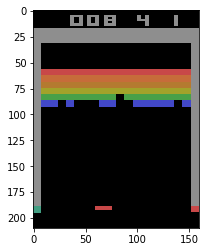

In [ ]:
# initialize a frame set to 0s
frames = np.zeros((1,WINDOW_LENGTH,)+INPUT_SHAPE)

# reset the observation
observation = env.reset()

# process the first observation as an initial frame set
myframe = processor.process_state_batch(processor.process_observation(observation))
for i in range(WINDOW_LENGTH):
    frames[:,i,:,:] = myframe
    
# show the observation initially
plt.imshow(observation)
clear_output(wait=True)
display(plt.gcf())

# initializers
done = False
iteration = 0

# main loop
while not done:
    
    # predict an action
    action = np.argmax(model.predict(frames))
    
    # Eps-soft?
    #if np.random.random() < 0.0:
    #    action = np.random.randint(env.action_space.n)
    
    # modify the action space by adding one
    modified_action = action+1
    observation,reward,done,_ = env.step(modified_action)
    
    # process the frame
    myframe = processor.process_state_batch(processor.process_observation(observation))
    
    # move the frame along
    frames[:,0:WINDOW_LENGTH-1,:,:] = frames[:,1:WINDOW_LENGTH,:,:]
    frames[:,WINDOW_LENGTH-1,:,:] = myframe
    
    # increment the iteration
    iteration += 1
    ## Skipping every 6th frame...
    ## This can be changed, but slows the rendering in JLab...
    if iteration % 6 == 0:
        plt.imshow(observation)
        clear_output(wait=True)
        display(plt.gcf())

clear_output(wait=True)